### Get distance_from_others data from combined_replicates/

In [422]:
# Imports
import json
import numpy as np
import plotly.plotly as py
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from matplotlib import cycler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import os
import glob2
import re

/Users/dieumynguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:


This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/dieumynguyen/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/dieumynguyen/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/dieumynguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/dieumynguyen/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/dieumynguyen/anaconda3/lib/python3.6/site-packages/ip

In [423]:
with open("combined_replicates/Q0.01_W0.005_D0.05_T0.001.json", "r") as f:
    data = json.load(f)

In [424]:
len(data[0]["Replicate 1"]["distance_from_others"])

8160

In [425]:
len(data)

2

### Get distances to 49 others for 1 bee over 160 timesteps

In [426]:
def get_data_1_bee(data, replicate_i, bee_start_i):
    # Loop over 50 lists in 1 timestep
    # Each list is 1 bee and its distance to 49 other bees at this timestep
    # List of 160 lists, each list has 50 values
    one_bee_160_t = []
    # Loop over 160 timesteps here
    for bee in range(bee_start_i, 8160, 51):  # for other bees: every 101?
        dist_to_49_others = data[replicate_i]["Replicate {}".format(replicate_i+1)]["distance_from_others"][bee]["distances"]
        one_bee_160_t.append(dist_to_49_others)

    return one_bee_160_t
    # bees_dict["Bee {}".format(i+1)] = dist_to_49_others

In [427]:
# Test function
# print(len(one_bee_160_t))
# print(one_bee_160_t)
bee_over_time = get_data_1_bee(data, 0, 0)
print(len(bee_over_time))
# bee_over_time[0]

160


### Threshold nearest neighbors at max = 2 distance units 

In [428]:
def get_avg_neighbor_distances(data_list):
    # Loop over each timestep list
    # List of 160 floats for 1 bee
    nearest_neighbors = []

    for t_list in data_list:
        # 160 avg values for distance to nearest neighbors
        avg_list = []
        for val in t_list:
            if val <= 2:
                avg_list.append(val)
                # print(val)
        nearest_neighbors.append(np.mean(avg_list))

    return nearest_neighbors

In [429]:
# Test
get_avg_neighbor_distances(bee_over_time)

[1.417915863048579,
 1.4202862837829588,
 1.4170239166854897,
 1.4200563596448819,
 1.4263809879890688,
 1.4321902285083998,
 1.4340166615384,
 1.4390302598828217,
 1.4310859966090166,
 1.433105442852127,
 1.4354469182977134,
 1.436090695983289,
 1.4317081335001336,
 1.4242849697403477,
 1.4192203350835015,
 1.4226348602219507,
 1.4351763798104096,
 1.4330269733653351,
 1.431996913557818,
 1.430559478987933,
 1.4214361311085695,
 1.4171652092020974,
 1.420486328233545,
 1.418842202177914,
 1.4217902015615278,
 1.4239695332738866,
 1.4317209270840847,
 1.4371829222813972,
 1.4444349929702132,
 1.4246632146703462,
 1.4207279264172925,
 1.4127479020929943,
 1.4060772575849163,
 1.4084567170799245,
 1.4005970959067175,
 1.3948822141346633,
 1.3912616864907543,
 1.387226451757845,
 1.3779395913196875,
 1.3810058080839247,
 1.3852838988840044,
 1.3810077914556367,
 1.3816506592447217,
 1.3831858677279592,
 1.388983388991614,
 1.3953098994975135,
 1.4343218454075228,
 1.443533433850691,
 1.45

### Use get_data_1_bee & get_avg_neighbor_distances to get 50 lists for 50 bees -- in 1 replicate  -- later average over all 10 replicates

In [430]:
def get_distances_50_bees(data, replicate_i):
    # List of 50 lists 
    neighbor_distances_all_bees = [] 

    for i in range(51):
        # print(i)
        one_bee = get_data_1_bee(data, replicate_i, i)
        avg_distances = get_avg_neighbor_distances(one_bee)
        neighbor_distances_all_bees.append(avg_distances)
        
    return neighbor_distances_all_bees

In [431]:
# Test
# get_distances_50_bees(data, 1)

In [432]:
def all_bees_all_time(data, replicate_i):
    ''' For 1 replicate swarm, get list of all bees avg distance
    from nearest neighbors over all 160 timesteps '''

    # Avg over all 50 bees for each of 160 timesteps
    # Get a list of 160 values
    all_distances = get_distances_50_bees(data, replicate_i)

    all_bees_over_time = []
    for i in range(160):
        # For each timestep, i, get values of each of the 50 bees at that i 
        one_t = [item[i] for item in all_distances]
        # Get the avg of of all bees at the timestep
        avg_all_bees = np.mean(one_t)
        all_bees_over_time.append(avg_all_bees)
        
    return all_bees_over_time

In [433]:
# Test
all_bees_all_time(data, 0)

[1.1443354443125366,
 1.146064093338625,
 1.1406952117956335,
 1.1382347576758263,
 1.1373210248513943,
 1.1213128576318134,
 1.1310401695307342,
 1.150538434142367,
 1.1402530947032892,
 1.1315640157990536,
 1.133763248581359,
 1.1276489646310293,
 1.121047658851818,
 1.140434804832558,
 1.1204207538447613,
 1.1244247107006375,
 1.1294664424702217,
 1.1394886359277443,
 1.1466829581624183,
 1.1442243231140679,
 1.146293984802749,
 1.1410817348587279,
 1.1343763838106844,
 1.1435715721288175,
 1.1390964544948894,
 1.1317386210807543,
 1.1295828080535972,
 1.1425019190441668,
 1.1421769377302053,
 1.1417973393297813,
 1.132860332331469,
 1.1455199485148326,
 1.1507765475510114,
 1.1515020916653687,
 1.1505224943502415,
 1.1500438738057817,
 1.1550029567198945,
 1.1485419936294108,
 1.1478934950870912,
 1.1524395323290595,
 1.1589795534156329,
 1.1593867489964367,
 1.1581152927075595,
 1.160010161603105,
 1.1575804652435002,
 1.155245098184478,
 1.1556647093585521,
 1.1590930165754199,
 

### Average over all replicates in JSON

In [434]:
# Get all replicates' lists into a list
all_replicates = []
for i in range(len(data)):
    one_replicate_data = all_bees_all_time(data, i)
    all_replicates.append(one_replicate_data)

In [435]:
# Store means of 10 replicates
all_reps_avgs = []

# Also get min and max for range in plotting 
mins = []; maxes = []

for i in range(160):
    one_timestep = [item[i] for item in all_replicates]
    # Get the avg of of all bees at the timestep
    avg_all_reps_all_bees = np.mean(one_timestep)
    min_val = min(one_timestep)
    max_val = max(one_timestep)
    
    all_reps_avgs.append(avg_all_reps_all_bees)
    mins.append(min_val)
    maxes.append(max_val)


In [436]:
def avg_all_replicates(data_json):
    # Get all replicates' lists into a list
    all_replicates = []
    for i in range(len(data_json)):
        one_replicate_data = all_bees_all_time(data_json, i)
        all_replicates.append(one_replicate_data)
        
    # Store means of 10 replicates
    all_reps_avgs = []

    # Also get min and max for range in plotting 
    mins = np.min(all_replicates, axis=0)
    maxs = np.max(all_replicates, axis=0)
    
    data = {
        "_all" : all_replicates,
        "_min" : mins,
        "_max" : maxs
    }

    return data

In [441]:
SIM_DATA = True

In [446]:
if SIM_DATA:
    real_seed = np.array(avg_all_replicates(data)["_all"])
    all_data = np.array([[ele + np.random.uniform(-0.05, .05) for ele in real_seed[np.random.randint(real_seed.shape[0])]] for _ in range(10)])
    min_data = np.min(new_data, axis=0)
    max_data = np.max(new_data, axis=0)
    
    _data = {"_all" : all_data, "_min" : min_data, "_max" : max_data}
else:
    _data = avg_all_replicates(data)
    

- Colorbrewer: http://colorbrewer2.org/#type=sequential&scheme=YlGnBu&n=5
- tsplot: https://seaborn.pydata.org/generated/seaborn.tsplot.html

In [447]:
def plot_me(_all, _min, _max):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    
    # Setup minmax bounds
    ax.plot(_min, color='#2c7fb8', alpha=0.5)
    ax.plot(_max, color='#41b6c4', alpha=0.5)
    
    # Fill between minmax bounds
    ax.fill_between([i for i in range(len(_min))], _min, _max, 
                    where = _max >= _min, facecolor='#ffffcc', alpha=0.25, interpolate=True)

    # Average with stds 68 and 95
    g = sns.tsplot(data=_all, estimator=np.mean, color="#253494", alpha=0.5, ci=[68, 95], ax=ax, err_kws={"color" : "#a1dab4", "alpha" : 0.55})
    g.lines[2].set_linewidth(4)

/Users/dieumynguyen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



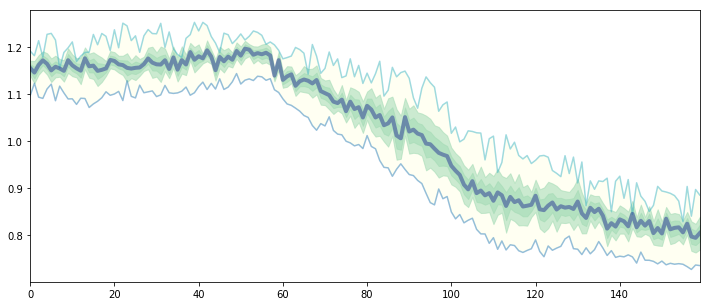

In [448]:
plot_me(**_data)